In [82]:
import tensorflow as tf
from utils import *

# AlexNet

In [81]:
class AlexNet(Classifier):
    def __init__(self, lr=0.1, num_outputs=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = tf.keras.models.Sequential([
            tf.keras.layers.Conv2D(
                96, kernel_size=11, strides=4, activation=tf.nn.relu),
            tf.keras.layers.MaxPool2D(pool_size=3, strides=2),
            tf.keras.layers.Conv2D(
                256, kernel_size=5, padding='same', activation=tf.nn.relu),
            tf.keras.layers.MaxPool2D(pool_size=3, strides=2),
            tf.keras.layers.Conv2D(
                384, kernel_size=3, padding='same', activation=tf.nn.relu),
            tf.keras.layers.Conv2D(
                384, kernel_size=3, padding='same', activation=tf.nn.relu),
            tf.keras.layers.Conv2D(
                256, kernel_size=3, padding='same', activation=tf.nn.relu),
            tf.keras.layers.MaxPool2D(pool_size=3, strides=2),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(4096, activation=tf.nn.relu),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(4096, activation=tf.nn.relu),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(num_outputs)
        ])

Construct a single-channel data example with both height and width of 224 to observe the output shape of each layer. 

In [6]:
with try_gpu():
    AlexNet().layer_summary((1, 224, 224, 1))

Conv2D output shape:	 (1, 54, 54, 96)
MaxPooling2D output shape:	 (1, 26, 26, 96)
Conv2D output shape:	 (1, 26, 26, 256)
MaxPooling2D output shape:	 (1, 12, 12, 256)
Conv2D output shape:	 (1, 12, 12, 384)
Conv2D output shape:	 (1, 12, 12, 384)
Conv2D output shape:	 (1, 12, 12, 256)
MaxPooling2D output shape:	 (1, 5, 5, 256)
Flatten output shape:	 (1, 6400)
Dense output shape:	 (1, 4096)
Dropout output shape:	 (1, 4096)
Dense output shape:	 (1, 4096)
Dropout output shape:	 (1, 4096)
Dense output shape:	 (1, 10)


Compared to LeNet, the main change here is the use of a smaller learning rate and much slower training due to the deeper and wider network, the higher image resolution, and the more costly convolutions.

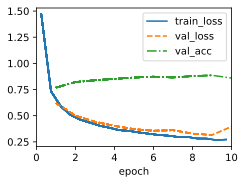

In [5]:
trainer = Trainer(max_epochs=10)
data = FashionMNIST(batch_size=128, resize=(224, 224))
with try_gpu():
    model = AlexNet(lr=0.01)
    trainer.fit(model, data)

Note that even though the number of parameters by far exceeds the amount of training data in our experiments (the last two layers have more than 40 million parameters, trained on a datasets of 60 thousand images), there is hardly any **overfitting**: training and validation loss are virtually identical throughout training. This is due to the improved regularization, such as ***Dropout***, inherent in modern deep network designs.

# Networks Using Blocks (VGG)
 

## VGG Block
A VGG block consists of a sequence of convolutions with 3x3 kernels with padding of 1 (keeping height and width) followed by a 2x2 max-pooling layer with stride of 2 (halving height and width after each block).

In [2]:
def vgg_block(num_convs, num_channels):
    blk = tf.keras.models.Sequential()
    for _ in range(num_convs):
        blk.add(
            tf.keras.layers.Conv2D(num_channels, kernel_size=3,
                                   padding='same', activation='relu')
        )
        blk.add(
            tf.keras.layers.MaxPool2D(pool_size=2, strides=2)
        )
    return blk

## VGG Network
The key difference is that VGG consists of blocks of layers, the convolutional layers are grouped in nonlinear transformations that leave the dimensonality unchanged, followed by a resolution-reduction step
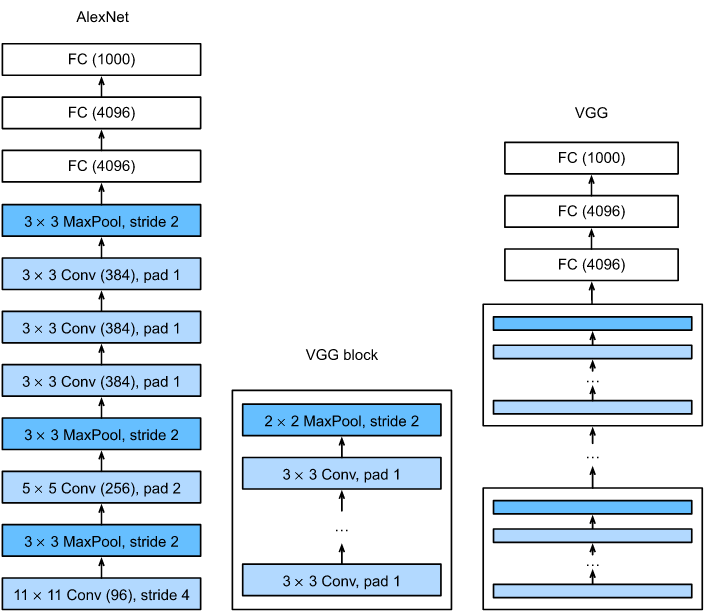

In [3]:
class VGG(Classifier):
    def __init__(self, arch, lr=0.1, num_outputs=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = tf.keras.models.Sequential()

        for num_convs, num_channels in arch:
            self.net.add(vgg_block(num_convs, num_channels))

        self.net.add(
            tf.keras.models.Sequential([
                tf.keras.layers.Flatten(),
                tf.keras.layers.Dense(4096, activation='relu'),
                tf.keras.layers.Dropout(0.5),
                tf.keras.layers.Dense(4096, activation='relu'),
                tf.keras.layers.Dropout(0.5),
                tf.keras.layers.Dense(num_outputs)
            ])
        )

In [4]:
VGG(arch=((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))
    ).layer_summary((1, 224, 224, 1))

2023-04-05 05:07:00.375403: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-05 05:07:00.376067: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-05 05:07:00.381689: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-05 05:07:00.382346: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-05 05:07:00.382697: I tensorflow/compiler/xla/stream_executo

Sequential output shape:	 (1, 112, 112, 64)
Sequential output shape:	 (1, 56, 56, 128)
Sequential output shape:	 (1, 14, 14, 256)
Sequential output shape:	 (1, 3, 3, 512)
Sequential output shape:	 (1, 0, 0, 512)
Sequential output shape:	 (1, 10)


We halve height and width at each block, finally reaching a height and width of 7 before flattening the representations for processing by the fully connected part of the network

In [ ]:
trainer = Trainer(max_epochs=10)
data = FashionMNIST(batch_size=8, resize=(28, 28))
with try_gpu(1):
    model = VGG(arch=((1, 16), (1, 32), (2, 64), (2, 128)),
                lr=0.01)
    trainer.fit(model, data)

2023-04-05 05:07:04.020711: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8204


It is VGG that arguably introduced key properties such as blocks of multiple convolutions and a preference for deep and narrow networks. 

# Network in Network (NiN)
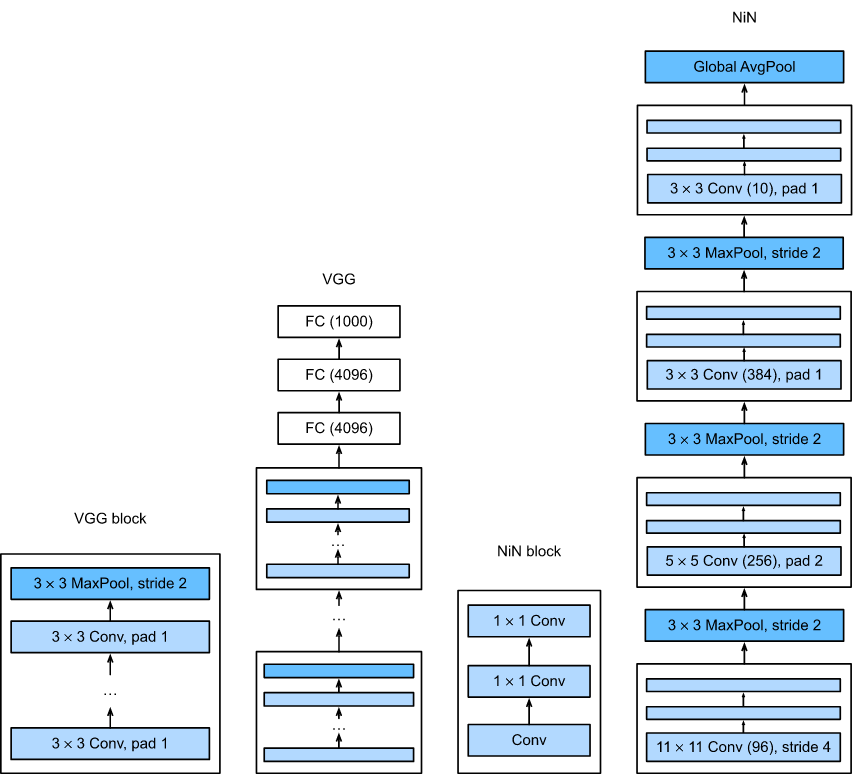

In [15]:
def nin_block(out_channels, kernel_size, strides, padding):
    blk = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(out_channels, kernel_size=kernel_size,
                               padding=padding, strides=strides, activation='relu'),
        tf.keras.layers.Conv2D(out_channels, kernel_size=1, activation='relu'),
        tf.keras.layers.Conv2D(out_channels, kernel_size=1, activation='relu')
    ])
    return blk

NiN uses the same initial convolution sizes as AlexNet. Each NiN block is followed by a max-pooling layer with a stride of 2 and a window shape of 3x3.

NiN avoids fully connected layers altogether. Instead, NiN uses **a NiN block with a number of output channels equal to the number of label classes**, followed by a **global average pooling layer**, yielding a vector of logits. 

This design significantly reduces the number of required model parameters, albeit at the expense of a potential increase in training time.

In [21]:
class NiN(Classifier):
    def __init__(self, lr=0.1, num_outputs=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = tf.keras.models.Sequential([
            nin_block(96, kernel_size=11, strides=4, padding='valid'),
            tf.keras.layers.MaxPool2D(pool_size=3, strides=2),
            nin_block(256, kernel_size=5, strides=1, padding='same'),
            tf.keras.layers.MaxPool2D(pool_size=3, strides=2),
            nin_block(384, kernel_size=3, strides=1, padding='same'),
            tf.keras.layers.MaxPool2D(pool_size=3, strides=2),
            tf.keras.layers.Dropout(0.5),
            nin_block(num_outputs, kernel_size=3, strides=1, padding='same'),
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Flatten()
        ])

In [20]:
NiN().layer_summary((1, 224, 224, 1))

Sequential output shape:	 (1, 54, 54, 96)
MaxPooling2D output shape:	 (1, 26, 26, 96)
Sequential output shape:	 (1, 26, 26, 256)
MaxPooling2D output shape:	 (1, 12, 12, 256)
Sequential output shape:	 (1, 12, 12, 384)
MaxPooling2D output shape:	 (1, 5, 5, 384)
Dropout output shape:	 (1, 5, 5, 384)
Sequential output shape:	 (1, 5, 5, 10)
GlobalAveragePooling2D output shape:	 (1, 10)
Flatten output shape:	 (1, 10)


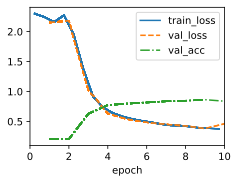

In [22]:
trainer = Trainer(max_epochs=10)
data = FashionMNIST(batch_size=128, resize=(224, 224))
with try_gpu():
    model = NiN(lr=0.05)
    trainer.fit(model, data)

# GoogLeNet

## Inception Blocks
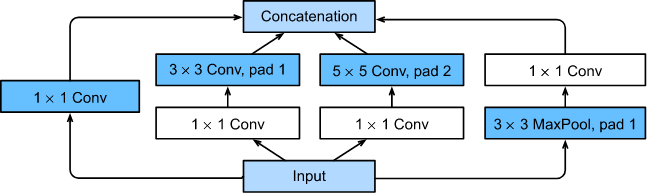

In [83]:
class Inception(tf.keras.Model):
    # c1--c4 are the number of output channels for each branch
    def __init__(self, c1, c2, c3, c4):
        super().__init__()
        self.b1_1 = tf.keras.layers.Conv2D(
            c1, kernel_size=1, activation='relu')
        self.b2_1 = tf.keras.layers.Conv2D(
            c2[0], kernel_size=1, activation='relu')
        self.b2_2 = tf.keras.layers.Conv2D(
            c2[1], kernel_size=3, padding='same', activation='relu')
        self.b3_1 = tf.keras.layers.Conv2D(
            c3[0], kernel_size=1, activation='relu')
        self.b3_2 = tf.keras.layers.Conv2D(
            c3[1], kernel_size=5, padding='same', activation='relu')
        self.b4_1 = tf.keras.layers.MaxPool2D(
            pool_size=3, strides=1, padding='same')
        self.b4_2 = tf.keras.layers.Conv2D(
            c4, kernel_size=1, activation='relu')

    def call(self, X):
        b1 = self.b1_1(X)
        b2 = self.b2_2(self.b2_1(X))
        b3 = self.b3_2(self.b3_1(X))
        b4 = self.b4_2(self.b4_1(X))
        return tf.keras.layers.Concatenate()([b1, b2, b3, b4])

## GoogLeNet Model
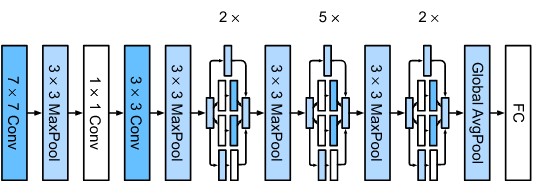

In [84]:
class GoogleNet(Classifier):
    def __init__(self, lr=0.01, num_outputs=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = tf.keras.models.Sequential(
            [self.b1(), self.b2(), self.b3(), self.b4(), self.b5(),
             tf.keras.layers.Dense(num_outputs)])

    def b1(self):
        return tf.keras.models.Sequential([
            tf.keras.layers.Conv2D(64, kernel_size=7, strides=2,
                                   padding='same', activation='relu'),
            tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')
        ])

    def b2(self):
        return tf.keras.models.Sequential([
            tf.keras.layers.Conv2D(64, kernel_size=1, activation='relu'),
            tf.keras.layers.Conv2D(192, kernel_size=3,
                                   padding='same', activation='relu'),
            tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')
        ])

    def b3(self):
        return tf.keras.models.Sequential([
            Inception(64, (96, 128), (16, 32), 32),
            Inception(128, (128, 192), (32, 96), 64),
            tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')
        ])

    def b4(self):
        return tf.keras.models.Sequential([
            Inception(192, (96, 208), (16, 48), 64),
            Inception(160, (112, 224), (24, 64), 64),
            Inception(128, (128, 256), (24, 64), 64),
            Inception(112, (144, 288), (32, 64), 64),
            Inception(256, (160, 320), (32, 128), 128),
            tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')
        ])

    def b5(self):
        return tf.keras.models.Sequential([
            Inception(256, (160, 320), (32, 128), 128),
            Inception(384, (192, 384), (48, 128), 128),
            # change the height and width of each channel to 1
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Flatten()
        ])

In [85]:
model = GoogleNet().layer_summary((1, 96, 96, 1))

Sequential output shape:	 (1, 24, 24, 64)
Sequential output shape:	 (1, 12, 12, 192)
Sequential output shape:	 (1, 6, 6, 480)
Sequential output shape:	 (1, 3, 3, 832)
Sequential output shape:	 (1, 1024)
Dense output shape:	 (1, 10)


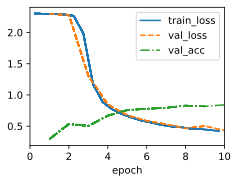

In [86]:
trainer = Trainer(max_epochs=10)
data = FashionMNIST(batch_size=128, resize=(96, 96))
with try_gpu():
    model = GoogleNet(lr=0.01)
    trainer.fit(model, data)

# Batch Normalization

## Implement from scratch

In [110]:
def batch_norm(X, gamma, beta, moving_mean, moving_var, eps):
    # Compute reciprocal of square root of the moving variance elementwise
    inv = tf.cast(tf.math.rsqrt(moving_var + eps), X.dtype)
    # Scale and shift
    return (X-moving_mean) * inv * gamma + beta

maintain moving averages of the means and variances for subsequent use during model prediction.



In [132]:
class BatchNorm(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(BatchNorm, self).__init__(**kwargs)

    def build(self, input_shape):
        weight_shape = [input_shape[-1], ]
        # The scale parameter and the shift parameter (model parameters) are
        # initialized to 1 and 0, respectively
        self.gamma = self.add_weight(name='gamma', shape=weight_shape,
                                     initializer=tf.initializers.ones, trainable=True)
        self.beta = self.add_weight(name='beta', shape=weight_shape,
                                    initializer=tf.initializers.zeros, trainable=True)

        # The variables that are not model parameters are initialized to 0
        self.moving_mean = self.add_weight(name='moving_mean', shape=weight_shape,
                                           initializer=tf.initializers.zeros, trainable=False)
        self.moving_variance = self.add_weight(name='moving_variance', shape=weight_shape,
                                               initializer=tf.initializers.ones, trainable=False)
        super(BatchNorm, self).build(input_shape)

    def assign_moving_average(self, variable, value):
        #  use momentum to govern the aggregation over past mean and variance estimates.
        momentum = 0.1
        delta = (1.0-momentum) * variable + momentum*value
        return variable.assign(delta)

    @tf.function
    def call(self, X, training):
        # X shape (1,28,28,3)
        if training:
            axes = list(range(len(X.shape) - 1))  # axes [0, 1, 2]
            batch_mean = tf.reduce_mean(
                X, axes, keepdims=True)  # shape (1, 1, 1, 3)
            batch_var = tf.reduce_mean(
                tf.math.squared_difference(X, tf.stop_gradient(batch_mean)),
                axes, keepdims=True)  # shape (1, 1, 1, 3)
            batch_mean = tf.squeeze(batch_mean, axes)  # shape (3,)
            batch_var = tf.squeeze(batch_var, axes)  # shape (3,)

            mean_update = self.assign_moving_average(
                self.moving_mean, batch_mean)  # shape (3,)
            var_update = self.assign_moving_average(
                self.moving_variance, batch_var)  # shape (3,)

            self.add_update(mean_update)  # update self.moving_mean
            self.var_update(var_update)  # update self.moving_variance
            mean, variance = batch_mean, batch_var

        else:
            mean, variance = self.moving_mean, self.moving_variance

        output = batch_norm(X, moving_mean=mean, moving_var=variance,
                            beta=self.beta, gamma=self.gamma, eps=1e-5)  # shape (1, 28, 28, 3)
        return output

In [133]:
class BNLeNet(Classifier):
    def __init__(self, lr=0.1, num_outputs=10):
        """apply BatchNorm to a traditional LeNet model """
        super().__init__()
        self.save_hyperparameters()
        self.net = tf.keras.models.Sequential([
            tf.keras.layers.Conv2D(6, kernel_size=5, input_shape=(28, 28, 1)),
            BatchNorm(),
            tf.keras.layers.Activation('sigmoid'),
            tf.keras.layers.AvgPool2D(pool_size=2, strides=2),
            tf.keras.layers.Conv2D(16, kernel_size=5),
            BatchNorm(),
            tf.keras.layers.Activation('sigmoid'),
            tf.keras.layers.AvgPool2D(pool_size=2, strides=2),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(120),
            BatchNorm(),
            tf.keras.layers.Activation('sigmoid'),
            tf.keras.layers.Dense(84),
            BatchNorm(),
            tf.keras.layers.Activation('sigmoid'),
            tf.keras.layers.Dense(num_outputs)
        ])

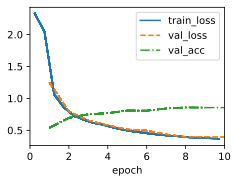

In [134]:
trainer = Trainer(max_epochs=10)
data = FashionMNIST(batch_size=128)
with try_gpu():
    model = BNLeNet(lr=0.5)
    trainer.fit(model, data)

## Concise Implementation

In [143]:
class BNLeNetKeras(Classifier):
    def __init__(self, lr=0.1, num_outputs=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = tf.keras.models.Sequential([
            tf.keras.layers.Conv2D(6, kernel_size=5, input_shape=(28, 28, 1)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Activation('sigmoid'),
            tf.keras.layers.AvgPool2D(pool_size=2, strides=2),
            tf.keras.layers.Conv2D(16, kernel_size=5),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Activation('sigmoid'),
            tf.keras.layers.AvgPool2D(pool_size=2, strides=2),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(120),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Activation('sigmoid'),
            tf.keras.layers.Dense(84),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Activation('sigmoid'),
            tf.keras.layers.Dense(num_outputs)
        ])

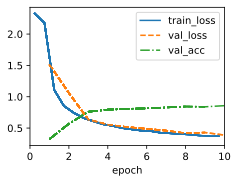

In [144]:
trainer = Trainer(max_epochs=10)
data = FashionMNIST(batch_size=128)
with try_gpu():
    model = BNLeNetKeras(lr=0.5)
    trainer.fit(model, data)

# Residual Networks (ResNet) and ResNeXt

## Residual Blocks
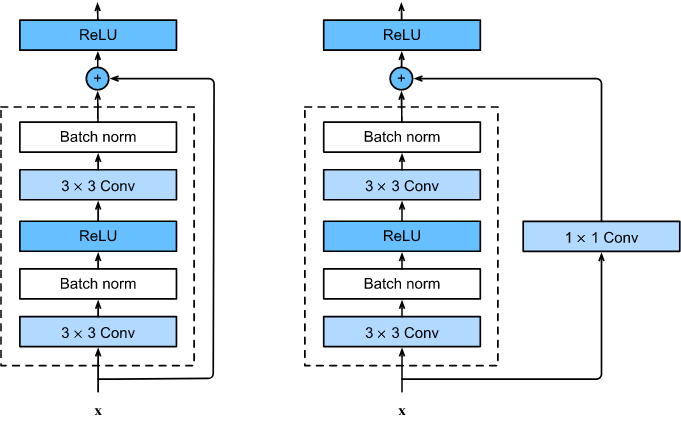

In [149]:
class Residual(tf.keras.Model):
    """The Residual block of ResNet models."""

    def __init__(self, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv2D(num_channels, kernel_size=3,
                                            strides=strides, padding='same')
        self.conv2 = tf.keras.layers.Conv2D(num_channels, kernel_size=3,
                                            padding='same')

        self.conv3 = None
        if use_1x1conv:
            # adjust channels and resolution by means of a 1X1 convolution before adding
            self.conv3 = tf.keras.layers.Conv2D(num_channels, kernel_size=1,
                                                strides=strides)
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.bn2 = tf.keras.layers.BatchNormalization()

    def call(self, X):
        Y = tf.keras.activations.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3 is not None:
            X = self.conv3(X)
        Y += X
        return tf.keras.activations.relu(Y)

In [150]:
blk = Residual(3)
X = tf.random.normal((4, 6, 6, 3))
Y = blk(X)
Y.shape

TensorShape([4, 6, 6, 3])

If we want to change the number of channels, we need to introduce an additional 1x1 convolutional layer to transform the input into the desired shape for the addition operation.

In [152]:
# halve the output height and width while increasing the number of output channels.
blk = Residual(6, use_1x1conv=True, strides=2)
X = tf.random.normal((4, 6, 6, 3))
Y = blk(X)
Y.shape

TensorShape([4, 3, 3, 6])

## ResNet Model
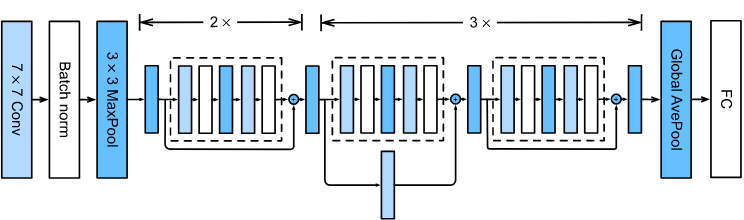

The first two layers of ResNet are the same as those of the GoogLeNet we described before: the 7x7 convolutional layer with 64 output channels and a stride of 2 is followed by the 3x3 max-pooling layer with a stride of 2. The difference is the batch normalization layer added after each convolutional layer in ResNet.

In [161]:
class ResNet(Classifier):
    def __init__(self, arch, lr=0.1, num_outputs=10):
        super().__init__()
        self.save_hyperparameters()
        self.net = tf.keras.models.Sequential(self.b1())

        for i, b in enumerate(arch):
            self.net.add(self.block(*b, first_block=(i == 0)))
        self.net.add(tf.keras.layers.GlobalAveragePooling2D())
        self.net.add(tf.keras.layers.Dense(num_outputs))

    def b1(self):
        return tf.keras.models.Sequential([
            tf.keras.layers.Conv2D(
                64, kernel_size=7, strides=2, padding='same'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Activation('relu'),
            tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')
        ])

    def block(self, num_residuals, num_channels, first_block=False):
        blk = tf.keras.models.Sequential()
        for i in range(num_residuals):
            if i == 0 and not first_block:
                # for the first block from the second modules to the end modules
                blk.add(Residual(num_channels, use_1x1conv=True, strides=2))
            else:
                blk.add(Residual(num_channels))
        return blk

In [165]:
class ResNet18(ResNet):
    def __init__(self, lr=0.1, num_outputs=10):
        super().__init__(((2, 64), (2, 128), (2, 256), (2, 512)),
                         lr, num_outputs)

In [166]:
ResNet18().layer_summary((1, 96, 96, 3))

Sequential output shape:	 (1, 24, 24, 64)
Sequential output shape:	 (1, 24, 24, 64)
Sequential output shape:	 (1, 12, 12, 128)
Sequential output shape:	 (1, 6, 6, 256)
Sequential output shape:	 (1, 3, 3, 512)
GlobalAveragePooling2D output shape:	 (1, 512)
Dense output shape:	 (1, 10)


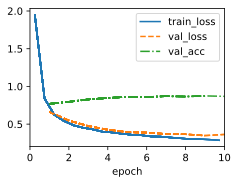

In [167]:
trainer = Trainer(max_epochs=10)
data = FashionMNIST(batch_size=128, resize=(96, 96))
with try_gpu():
    model = ResNet18(lr=0.01)
    trainer.fit(model, data)

## ResNeXt 
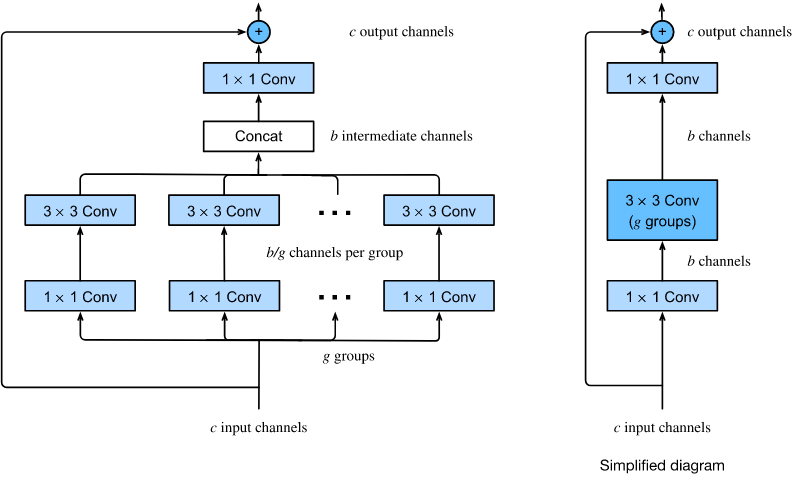

In [192]:
class ResNeXtBlock(tf.keras.Model):
    """The ResNeXt block."""
    def __init__(self, num_channels, groups, bot_mul, use_1x1conv=False,
                 strides=1):
        super().__init__()
        bot_channels = int(round(num_channels * bot_mul))
        self.conv1 = tf.keras.layers.Conv2D(bot_channels, 1, strides=1)
        self.conv2 = tf.keras.layers.Conv2D(bot_channels, 3, strides=strides,
                                           padding='same', groups=bot_channels//groups)
        self.conv3 = tf.keras.layers.Conv2D(num_channels, 1, strides=1)
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.bn3 = tf.keras.layers.BatchNormalization()
        if use_1x1conv:
            self.conv4 = tf.keras.layers.Conv2D(bot_channels, 1, strides=strides)
            self.bn4 = tf.keras.layers.BatchNormalization()
        else:
            self.conv4 = None
            
    def call(self, X):
        Y = tf.keras.activations.relu(self.bn1(self.conv1(X)))
        Y = tf.keras.activations.relu(self.bn2(self.conv2(Y)))
        Y = self.bn3(self.conv3(Y))
        if self.conv4:
            X = self.bn4(self.conv4(X))
        return tf.keras.activations.relu(Y+X)    


In [193]:
blk = ResNeXtBlock(num_channels=32, groups=16, bot_mul=1)
X = tf.random.normal((4,96,96,32))
blk(X).shape

TensorShape([4, 96, 96, 32])

# Densely Connected Networks (DenseNet)

## Dense Blocks

In [177]:
class ConvBlock(tf.keras.layers.Layer):
    def __init__(self, num_channels):
        super(ConvBlock, self).__init__()
        # DenseNet uses the modified “batch normalization, activation, and convolution” structure of ResNet
        self.bn = tf.keras.layers.BatchNormalization()
        self.relu = tf.keras.layers.ReLU()
        self.conv = tf.keras.layers.Conv2D(
            num_channels, kernel_size=3, padding='same')
        self.listLayers = [self.bn, self.relu, self.conv]

    def call(self, x):
        y = x
        for layer in self.listLayers:
            y = layer(y)
        y = tf.keras.layers.concatenate([x, y], axis=-1)
        return y

A dense block consists of multiple convolution blocks, each using the same number of output channels. 

In [178]:
class DenseBlock(tf.keras.layers.Layer):
    def __init__(self, num_convs, num_channels):
        super(DenseBlock, self).__init__()
        self.listLayers = []
        for _ in range(num_convs):
            self.listLayers.append(ConvBlock(num_channels))

    def call(self, X):
        for layer in self.listLayers.layers:
            X = layer(X)
        return X

Define a DenseBlock instance with 2 convolution blocks of 10 output channels. When using an input with 3 channels, we will get an output with 
3+10+10=23 channels. The number of convolution block channels controls the growth in the number of output channels relative to the number of input channels. This is also referred to as the growth rate.

In [179]:
blk = DenseBlock(2, 10)
X = tf.random.normal((4, 8, 8, 3))
Y = blk(X)
Y.shape

TensorShape([4, 8, 8, 23])

## Transition Layers

In [183]:
class TransitionBlock(tf.keras.layers.Layer):
    def __init__(self, num_channels, **kwargs):
        super(TransitionBlock, self).__init__(**kwargs)
        self.batch_norm = tf.keras.layers.BatchNormalization()
        self.relu = tf.keras.layers.ReLU()
        # reduces the number of channels by using an 1X1 convolution.
        self.conv = tf.keras.layers.Conv2D(num_channels, kernel_size=1)
        self.avg_pool = tf.keras.layers.AvgPool2D(pool_size=2, strides=2)

    def call(self, X):
        X = self.batch_norm(X)
        X = self.relu(X)
        X = self.conv(X)
        return self.avg_pool(X)

Apply a transition layer with 10 channels to the output of the dense block . This reduces the number of output channels to 10, and halves the height and width.

In [184]:
blk = TransitionBlock(10)
blk(Y).shape

TensorShape([4, 4, 4, 10])

## DenseNet Model
DenseNet first uses the same single convolutional layer and max-pooling layer as in ResNet.

DenseNet uses four dense blocks,  set the number of channels (i.e., growth rate) for the convolutional layers in the dense block to 32, so 128 channels will be added to each dense block.

In [187]:
class DenseNet(Classifier):
    def __init__(self, num_channels=64, growth_rate=32, arch=(4,4,4,4), lr=0.1, num_outputs=10):
        super(DenseNet, self).__init__()
        self.save_hyperparameters()
        self.net = tf.keras.models.Sequential(self.b1())
        for i, num_convs in enumerate(arch):
            self.net.add(DenseBlock(num_convs, growth_rate))
            # The number of output channels in the previous dense block
            num_channels += num_convs * growth_rate
            # A transition layer that halves the number of channels is added
            # between the dense blocks
            if i != len(arch)-1:
                num_channels //= 2
                self.net.add(TransitionBlock(num_channels))
                
        self.net.add(tf.keras.layers.BatchNormalization())
        self.net.add(tf.keras.layers.ReLU())
        self.net.add(tf.keras.layers.GlobalAveragePooling2D())
        self.net.add(tf.keras.layers.Flatten())
        self.net.add(tf.keras.layers.Dense(num_outputs))
        
    def b1(self):
        return tf.keras.models.Sequential([
            tf.keras.layers.Conv2D(
                64, kernel_size=7, strides=2, padding='same'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Activation('relu'),
            tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')
        ])

In [189]:
DenseNet().layer_summary((1,96,96,3))

Sequential output shape:	 (1, 24, 24, 64)
DenseBlock output shape:	 (1, 24, 24, 192)
TransitionBlock output shape:	 (1, 12, 12, 96)
DenseBlock output shape:	 (1, 12, 12, 224)
TransitionBlock output shape:	 (1, 6, 6, 112)
DenseBlock output shape:	 (1, 6, 6, 240)
TransitionBlock output shape:	 (1, 3, 3, 120)
DenseBlock output shape:	 (1, 3, 3, 248)
BatchNormalization output shape:	 (1, 3, 3, 248)
ReLU output shape:	 (1, 3, 3, 248)
GlobalAveragePooling2D output shape:	 (1, 248)
Flatten output shape:	 (1, 248)
Dense output shape:	 (1, 10)


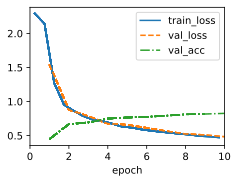

In [188]:
trainer = Trainer(max_epochs=10)
data = FashionMNIST(batch_size=128, resize=(96,96))
with try_gpu():
    model = DenseNet(lr=0.01)
    trainer.fit(model, data)